In [1]:
# %autosave 60
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os, sys, traceback
os.environ["OPENBLAS_NUM_THREADS"] = "16"

from copy import deepcopy as copy
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("Location_of_s3fit"))
from s3fit import FitFrame

# Example data

In [2]:
intspec_all_tw = fits.open('J1126_intspec_tw.fits')[0].data
spec_wave_w = intspec_all_tw[0]
spec_flux_w = intspec_all_tw[1]
spec_ferr_w = intspec_all_tw[2]

spec_valid_range = [[4950, 5074], [5120, 5240], [5280, 6420], [6500, 10050]]
spec_R_inst = 631 / 0.31 * 0.5
spec_flux_scale = 1e-15

v0_redshift = 0.4684

In [3]:
phot_name_b = np.array(['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4'])
phot_flux_b = np.array([5.5153001e-02, 8.1697002e-02, 1.6868000e-01, 2.3030201e-01,
       2.9083699e-01, 2.6506501e-01, 5.1317799e-01, 6.0935998e-01,
       6.5717798e-01, 7.9932898e-01, 1.6560427e+01, 9.2305588e+01])
phot_ferr_b = np.array([5.37700020e-04, 7.42999837e-05, 7.90003687e-05, 1.22798607e-04,
       1.38930045e-03, 4.11554985e-02, 2.27502026e-02, 1.14961006e-01,
       2.30419636e-03, 2.99510360e-03, 3.06923389e-02, 3.02008629e-01])

phot_trans_dir='../filters/'

# Set models

In [4]:
# ssp_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], [-1, -1, 'fix'], [-1, -1, 'fix']], 
#                        'info': {'age_min': 5.5e-3, 'age_max': 'universe', 'met_sel': 'solar', 'sfh': 'nonparametric'} } }
ssp_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], 
                                [0, 0.94, 'free'], [-1, 1, 'free']], 
                       'info': {'age_min': -2.25, 'age_max': 'universe', 'met_sel': 'solar', 'sfh': 'exponential'} }, 
              'young': {'pars': [[None, None, 'ssp:main:0'], [None, None, 'ssp:main:1'], [None, None, 'ssp:main:2'], 
                                 [-2, -1, 'free'], [-1, -1, 'fix']], 
                        'info': {'age_min': -2.25, 'age_max': 0, 'met_sel': 'solar', 'sfh': 'constant'} } }
# pars: voff, fwhm, AV, log csp_age (Gyr), log sfh_tau (Gyr)
# age_min, age_max: min and max log ssp_age (Gyr)
# met_sel: 'all', 'solar', or any combination of [0.004,0.008,0.02,0.05]
# sfh: 'nonparametric', 'exponential', 'delayed', 'constant'
ssp_file = '../models/popstar21_stellar_nebular_fullwave.fits'
# please use ../models/convert_popstar_ssp.py to create the ssp template library

el_config = {'NLR': {'pars':       [[ -500,   500, 'free'], [250,  750, 'free'], [0, 5, 'free'], [0.5, 1.45, 'free']], 
                     'info': {'line_used': ['all']}}, 
             'outflow_1': {'pars': [[-2000,   100, 'free'], [750, 2500, 'free'], [0, 5, 'free'], [0.5, 1.45, 'free']], 
                           'info': {'line_used': ['all']}}, 
             'outflow_2': {'pars': [[-3000, -2000, 'free'], [750, 2500, 'free'], [0, 5, 'free'], [0.5, 1.45, 'free']], 
                           'info': {'line_used': ['[OIII]a', '[OIII]b', '[NII]a', 'Ha', '[NII]b']} } }
# pars: voff, fwhm, AV, SIIa/b (n_e: 1e4--1cm-3); 3 kinematic system

agn_config = {'main': {'pars': [[None, None, 'el:NLR:0;ssp:main:0'], [None, None, 'el:NLR:1;ssp:main:1'], [1.5, 10.0, 'free'], [-1.7, None, 'fix']],
                       'info': {'mod_used': ['powerlaw']} } }
# pars: voff, fwhm, AV; alpha_lambda of powerlaw at 

torus_config = {'main': {'pars': [[None, None, 'el:NLR:0;ssp:main:0'], [3, 11, 'free'], [10, 80, 'free'], [10, 30, 'free'], [0, 90, 'free']],
                         'info': {'mod_used': ['dust']} } } # 
# pars: voff, tau, opening angle, radii ratio, inclination angle
# set 'mod_used' to ['disc', 'dust'] if use both of disc and dusty torus modules
torus_file = '../models/skirtor_torus.fits'

model_config = {'ssp': {'enable': True, 'config': ssp_config, 'file': ssp_file}, 
                'el': {'enable': True, 'config': el_config}, 
#                 'agn': {'enable': True, 'config': agn_config}, # do not use agn powerlaw since the example is type-2
                'torus': {'enable': True, 'config': torus_config, 'file': torus_file}}

# Pure spec fit

In [5]:
FF_noSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    # phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=0, plot_step=True, print_step=False, verbose=False)
                    # set num_mock_loops=0 to only fit the raw data, i.e., no mocked spectra
                    # set plot=1 to plot each fitting step

v1.4, 250126: (1) support flexible SFH
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line complex 0 NLR , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 1 outflow_1 , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 2 outflow_2 , total number: 5 , free lines: ['Ha' '[NII]b' '[OIII]b']
#### Models used in the fitting: ssp+el+torus ####


#### loop 0/1 start: ####
#### fit the raw spectrum (non-mocked) ####


/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:113: RuntimeWarning: invalid value encountered in divide
  p_norm = norm(suf / denom)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/xiayngcn/miniforge3

1 loops have good fit, chi_sq: [1.9223505]
0 loops need refit, chi_sq: []
#### loop 0/1 end, 42.4 s ####
######## 1 successful loops in total 1 loops ########

Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     1.9224
| Redshift                         =     0.4684 +/- nan
| Velocity dispersion (km/s)       =   373.7079 +/- nan
| Extinction (AV)                  =     1.4453 +/- nan
| log Age_max of CSP (Gyr)         =     0.7238 +/- nan
| log Tau of SFH (Gyr)             =    -0.2653 +/- nan
| F5500(rest) (1e-15 erg/s/cm2/AA) =     0.0028 +/- nan
| log L5500(rest) (Lsun/AA)        =     6.5304 +/- nan
| log Mass (all formed) (Msun)     =    10.8097 +/- nan
| log Mass (remainning) (Msun)     =    10.6154 +/- nan
| log M/L5500 (Msun/(Lsun/AA))     =     4.0849 +/- nan
| Lum-weight log Age (Gyr)         =     0.6572 +/- nan
| Mass-weight log Age (Gyr)        =     0.6663 +/- nan
| Lum-weight log Metallicity (Z)   =    -1.699

/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


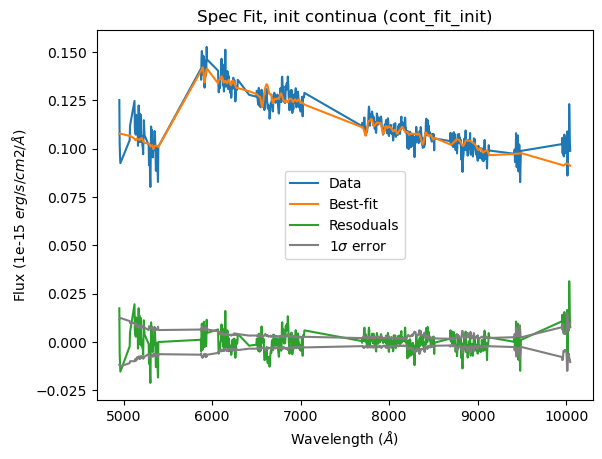

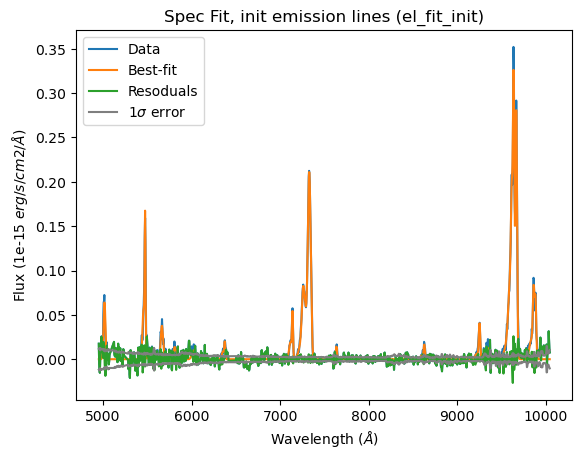

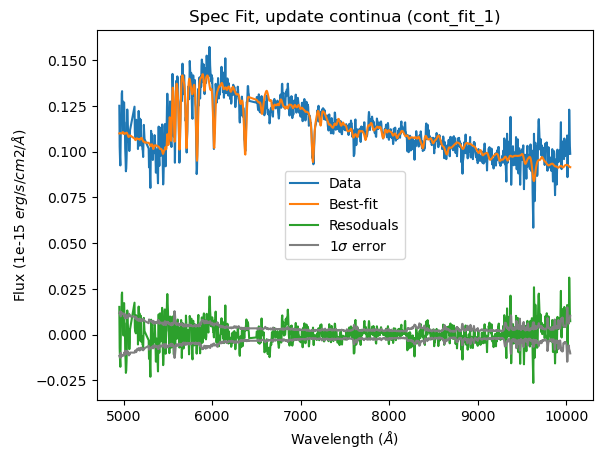

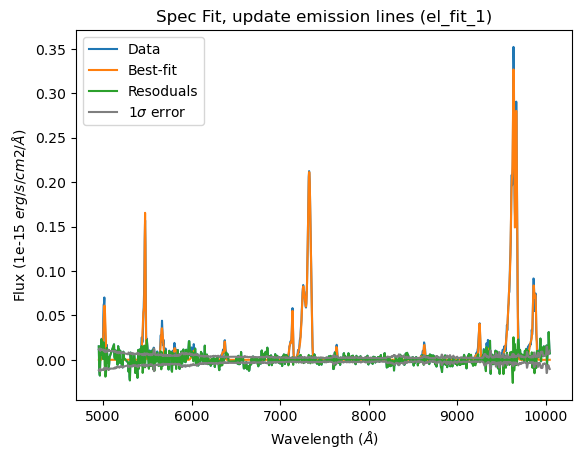

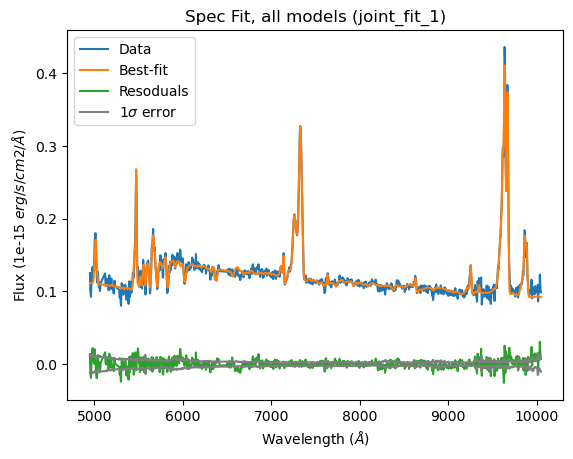

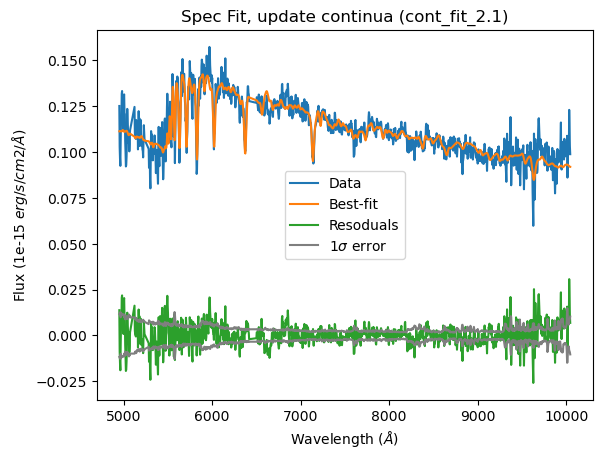

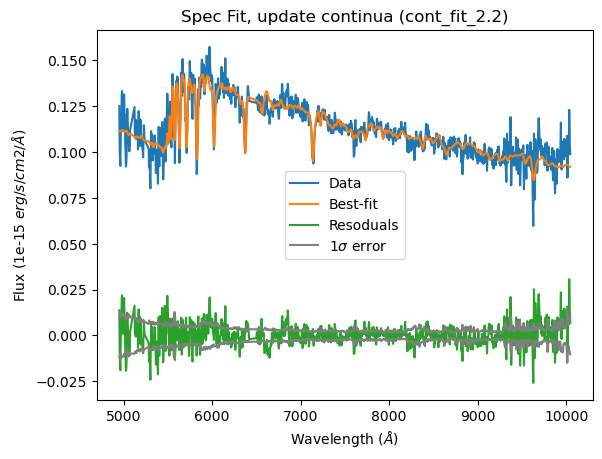

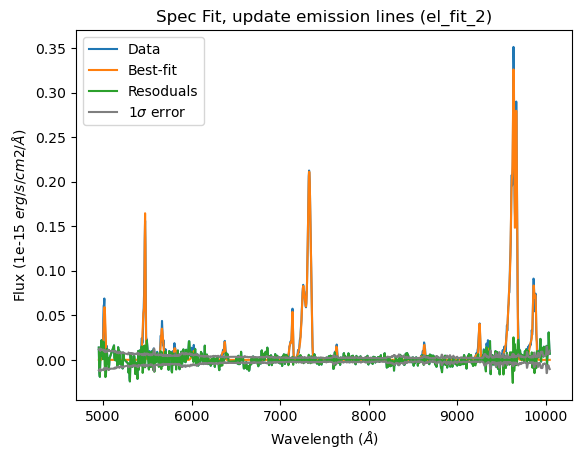

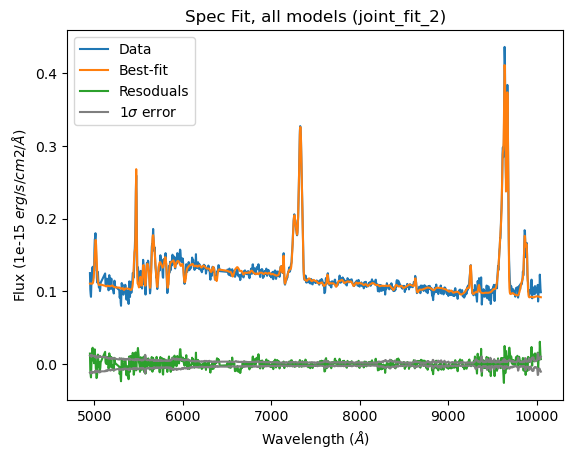

In [6]:
FF_noSED_biSFH.main_fit()

# Spec + SED fit

In [8]:
FF_wSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=0, plot_step=True, print_step=True, verbose=False)
                    # num_mock_loops=0 to only fit the raw data, i.e., no mocked spectra
                    # set plot=1 to plot each fitting step

v1.4, 250126: (1) support flexible SFH
Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line complex 0 NLR , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 1 outflow_1 , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 2 outflow_2 , total number: 5 , free lines: ['Ha' '[NII]b' '[OIII]b']
#### Models used in the fittin

#### loop 0/1 start: ####
#### fit the raw spectrum (non-mocked) ####
Continuum models: ssp
Number of used CSP models: 2
fit_ntry=1, chi_sq=1.799
**** Spec Fit, init continua (cont_fit_init), 4.2 s; totally spent, 4.2 s ****
fit_ntry=1, chi_sq=1.995
**** Spec Fit, init emission lines (el_fit_init), 4.5 s; totally spent, 8.8 s ****
Number of used CSP models: 2
fit_ntry=1, chi_sq=1.907
**** Spec Fit, update continua (cont_fit_1), 7.7 s; totally spent, 16.5 s ****
fit_ntry=1, chi_sq=1.932
**** Spec Fit, update emission lines (el_fit_1), 2.3 s; totally spent, 18.8 s ****
fit_ntry=1, chi_sq=1.927
**** Spec Fit, all models (joint_fit_1), 24.0 s; totally spent, 42.8 s ****
ssp continuum peak SN=53.12839169756829, enabled
#### continuum models after examination: ssp ####
NLR pean SN=47.455205740501064, enabled
outflow_1 pean SN=27.486891093080082, enabled
outflow_2 pean SN=13.207545853986591, enabled
#### emission line components after examination: ['NLR', 'outflow_1', 'outflow_2'] ####
fit_nt

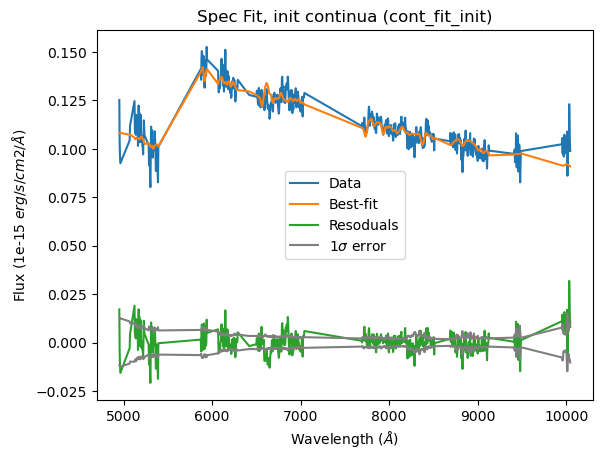

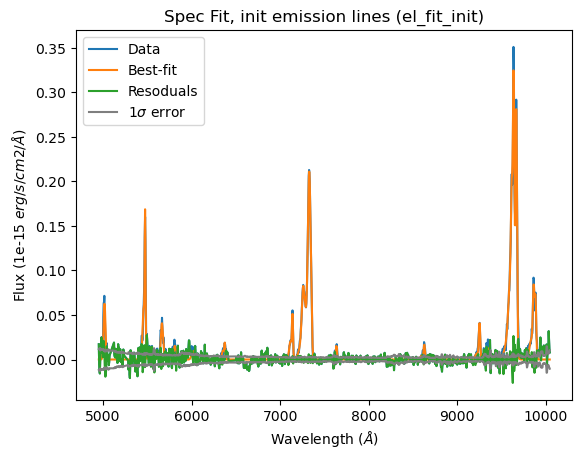

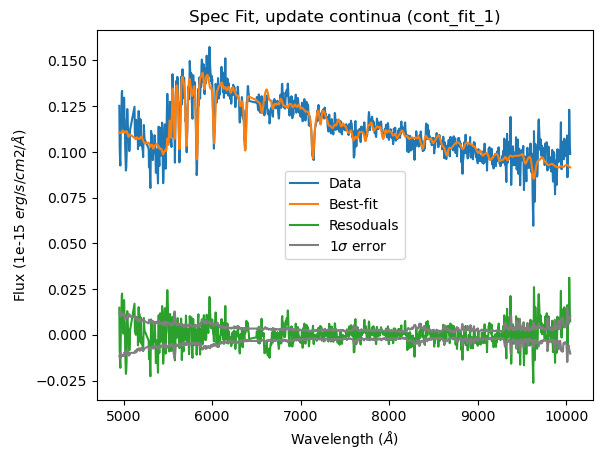

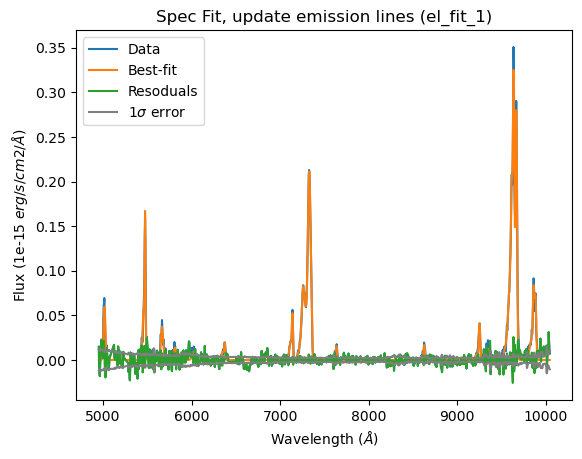

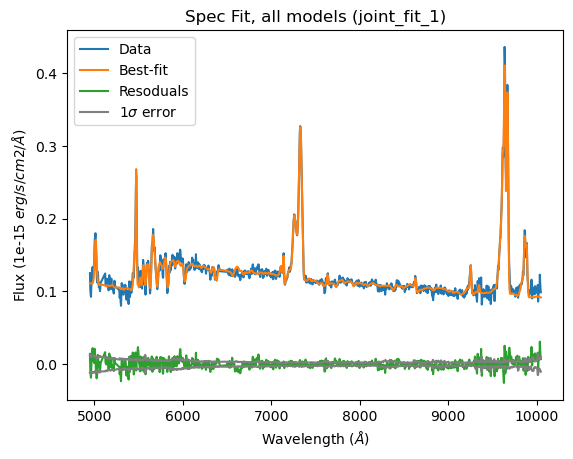

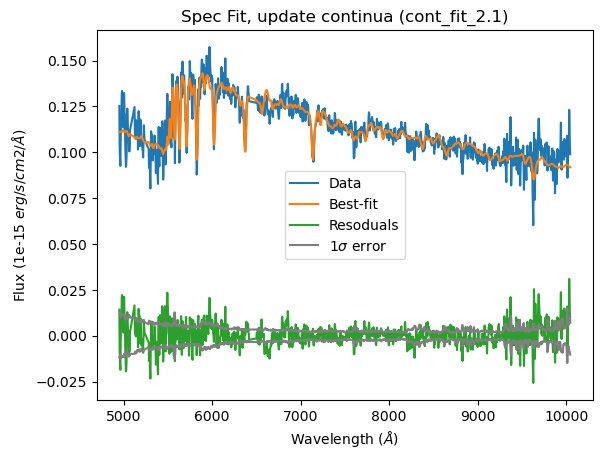

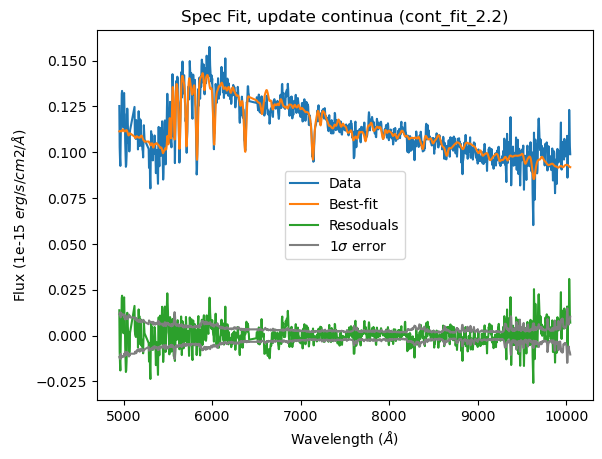

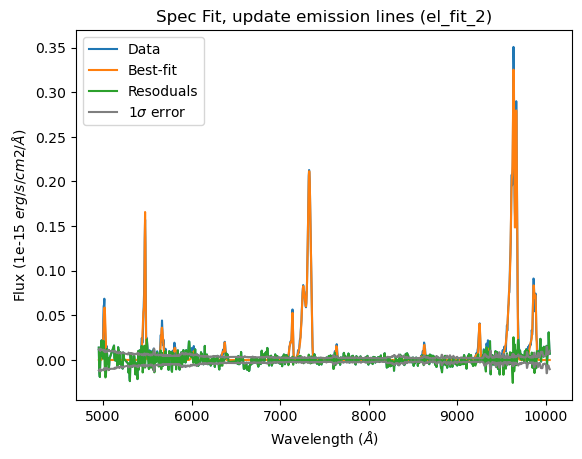

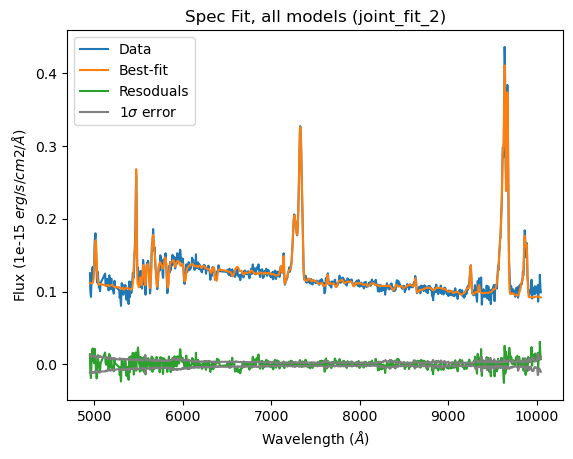

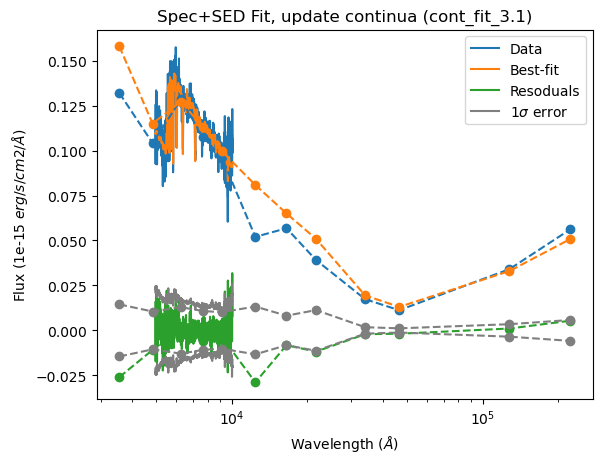

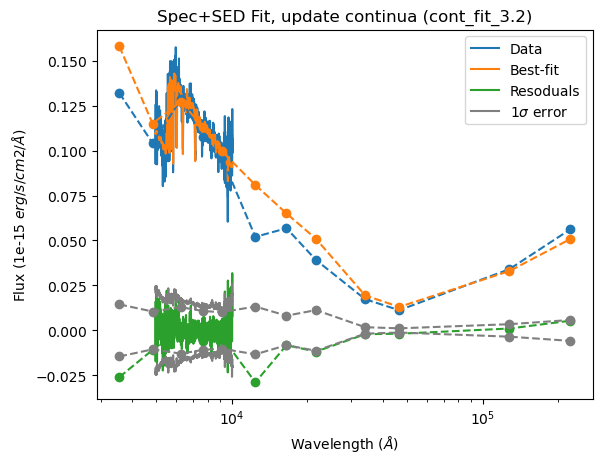

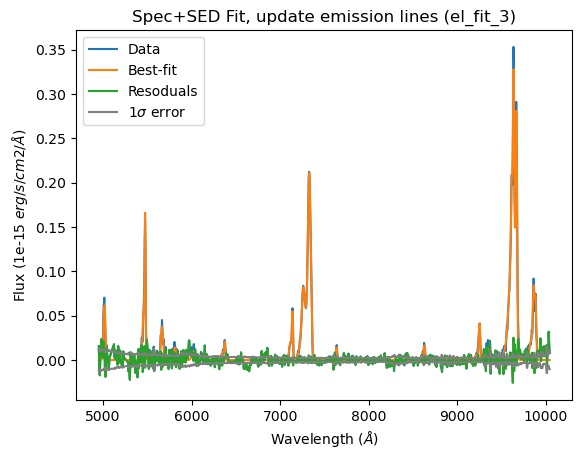

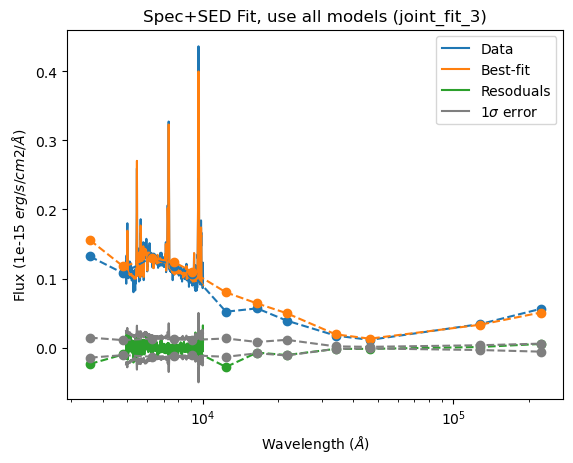

In [10]:
# run fit
FF_wSED_biSFH.main_fit()

# Spec + SED fit with mocked spectra (for uncertainty estimation)

In [11]:
FF_wSED_biSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=10, plot_step=False, print_step=False, verbose=False)
                    # set num_mock_loops=10 to create 10 mocked spectra

v1.4, 250126: (1) support flexible SFH
Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line complex 0 NLR , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 1 outflow_1 , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 2 outflow_2 , total number: 5 , free lines: ['Ha' '[NII]b' '[OIII]b']
#### Models used in the fittin

In [12]:
# run fit
FF_wSED_biSFH_mock10.main_fit()

#### loop 0/11 start: ####
#### fit the raw spectrum (non-mocked) ####
#### loop 0/11 end, 121.8 s ####
#### loop 1/11 start: ####
#### fit the mocked spectrum ####
#### loop 1/11 end, 167.9 s ####
#### loop 2/11 start: ####
#### fit the mocked spectrum ####
#### loop 2/11 end, 90.2 s ####
#### loop 3/11 start: ####
#### fit the mocked spectrum ####
#### loop 3/11 end, 104.7 s ####
#### loop 4/11 start: ####
#### fit the mocked spectrum ####
#### loop 4/11 end, 92.4 s ####
#### loop 5/11 start: ####
#### fit the mocked spectrum ####
#### loop 5/11 end, 118.4 s ####
#### loop 6/11 start: ####
#### fit the mocked spectrum ####
#### loop 6/11 end, 116.7 s ####
#### loop 7/11 start: ####
#### fit the mocked spectrum ####


/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q


#### loop 7/11 end, 99.7 s ####
#### loop 8/11 start: ####
#### fit the mocked spectrum ####
#### loop 8/11 end, 92.8 s ####
#### loop 9/11 start: ####
#### fit the mocked spectrum ####
#### loop 9/11 end, 124.5 s ####
#### loop 10/11 start: ####
#### fit the mocked spectrum ####
11 loops have good fit, chi_sq: [0.1342037  0.19453023 0.20163376 0.18759047 0.201924   0.21045409
 0.2109646  0.19917778 0.18077779 0.20056901 0.20743463]
0 loops need refit, chi_sq: []
#### loop 10/11 end, 85.0 s ####
######## 11 successful loops in total 11 loops ########

Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     0.1342
| Redshift                         =     0.4684 +/- 0.0001
| Velocity dispersion (km/s)       =   348.1712 +/- 13.7576
| Extinction (AV)                  =     1.3057 +/- 0.0457
| log Age_max of CSP (Gyr)         =     0.1877 +/- 0.0403
| log Tau of SFH (Gyr)             =     0.5124 +/- 0.4251
| F5500(rest) (1e-15 erg

In [15]:
# set another fit with nonparametric SFH
ssp_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], [-1, -1, 'fix'], [-1, -1, 'fix']], 
                       'info': {'age_min': -2.25, 'age_max': 'universe', 'met_sel': 'solar', 'sfh': 'nonparametric'} } }
model_config = {'ssp': {'enable': True, 'config': ssp_config, 'file': ssp_file}, 
                'el': {'enable': True, 'config': el_config}, 
#                 'agn': {'enable': True, 'config': agn_config}, # do not use agn powerlaw since the example is type-2
                'torus': {'enable': True, 'config': torus_config, 'file': torus_file}}

FF_wSED_npSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=10, plot_step=False, print_step=False, verbose=False)
                    # set num_mock_loops=10 to create 10 mocked spectra

v1.4, 250126: (1) support flexible SFH
Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['nonparametric']
Emission line complex 0 NLR , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 1 outflow_1 , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 2 outflow_2 , total number: 5 , free lines: ['Ha' '[NII]b' '[OIII]b']
#### Models used in the fitting: ssp+el

In [19]:
# run fit
FF_wSED_npSFH_mock10.main_fit()

#### loop 0/11 start: ####
#### fit the raw spectrum (non-mocked) ####


/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:113: RuntimeWarning: invalid value encountered in divide
  p_norm = norm(suf / denom)
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/opti

#### loop 0/11 end, 222.0 s ####
#### loop 1/11 start: ####
#### fit the mocked spectrum ####


/home/xiayngcn/miniforge3/envs/py3/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:156: RuntimeWarning: invalid value encountered in scalar add
  alpha -= (phi + Delta) * ratio / Delta


#### loop 1/11 end, 257.5 s ####
#### loop 2/11 start: ####
#### fit the mocked spectrum ####
#### loop 2/11 end, 146.6 s ####
#### loop 3/11 start: ####
#### fit the mocked spectrum ####
#### loop 3/11 end, 218.5 s ####
#### loop 4/11 start: ####
#### fit the mocked spectrum ####
#### loop 4/11 end, 172.2 s ####
#### loop 5/11 start: ####
#### fit the mocked spectrum ####
#### loop 5/11 end, 256.9 s ####
#### loop 6/11 start: ####
#### fit the mocked spectrum ####
#### loop 6/11 end, 177.6 s ####
#### loop 7/11 start: ####
#### fit the mocked spectrum ####
#### loop 7/11 end, 248.8 s ####
#### loop 8/11 start: ####
#### fit the mocked spectrum ####
#### loop 8/11 end, 164.1 s ####
#### loop 9/11 start: ####
#### fit the mocked spectrum ####
#### loop 9/11 end, 175.3 s ####
#### loop 10/11 start: ####
#### fit the mocked spectrum ####
10 loops have good fit, chi_sq: [0.13018461 0.1836695  0.20981005 0.20425343 0.21213243 0.20432671
 0.19929346 0.19772209 0.19508127 0.20134123]
1 loops 

# Output best-fit spectra

In [100]:
# use the case FF_wSED_biSFH_mock10 for an example
FF = copy(FF_wSED_biSFH_mock10)
# the best-fit spectra are stored in FF.spec and FF.sed
# FF.spec is in the range of the observed spectrum; FF.sed is in the range of the full SED
print(f"Names of available best-fit model spectra: {[name for name in [*FF.spec] if name[:4] == 'fmod']}")

Names of available best-fit model spectra: ['fmod_ssp_w', 'fmod_el_w', 'fmod_torus_w', 'fmod_tot_w']


In [85]:
# FF.spec['fmod_el_w'] is the sum of all emission line components
# here create emission line spectra of each component
# the components are set in the input el_config

i_l = 0 # use the first loop, i.e., the fit for raw data (i_l > 1 for mocked ones)
el_mod = FF.model_dict['el']['specmod']
bp0, bp1, bc0, bc1 = FF.model_index('el', FF.full_model_type)

# narrow line component
i_p0, i_p1 = 0, el_mod.mask_free_cn[0].sum()
el_model_N = np.dot(FF.best_coeffs[i_l, bc0:bc1][i_p0:i_p1], 
                               el_mod.models_unitnorm_obsframe(FF.spec['wave_w'], FF.best_fits_x[i_l, bp0:bp1])[i_p0:i_p1])
# the 1st outflow broad line component
i_p0, i_p1 = i_p1, i_p1+el_mod.mask_free_cn[1].sum()
el_model_B1 = np.dot(FF.best_coeffs[i_l, bc0:bc1][i_p0:i_p1], 
                               el_mod.models_unitnorm_obsframe(FF.spec['wave_w'], FF.best_fits_x[i_l, bp0:bp1])[i_p0:i_p1])
# the 2nd outflow broad line component
i_p0, i_p1 = i_p1, i_p1+el_mod.mask_free_cn[2].sum()
el_model_B2 = np.dot(FF.best_coeffs[i_l, bc0:bc1][i_p0:i_p1], 
                               el_mod.models_unitnorm_obsframe(FF.spec['wave_w'], FF.best_fits_x[i_l, bp0:bp1])[i_p0:i_p1])

Text(0.5, 1.0, 'The best-fit spectra in the wavelength range of the data spectrum.')

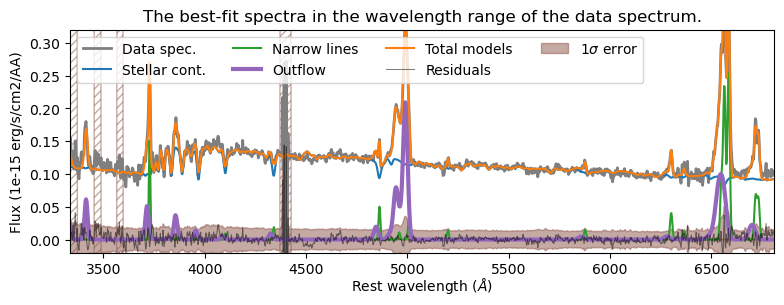

In [103]:
# best-fit spectra in the wavelength range of the data spectrum.
tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.08,bottom=0.06,right=0.96,top=0.98,wspace=0,hspace=0.15)

ax1 = plt.subplot(3, 1, 1)
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', linewidth=2, label='Data spec.')
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_ssp_w'], c='C0', label='Stellar cont.')
# plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_el_w'], c='C3', label='All emission lines')
ax1.plot(FF.spec['wave_w']/tmp_z, el_model_N, c='C2', label='Narrow lines')
ax1.plot(FF.spec['wave_w']/tmp_z, el_model_B1+el_model_B2, c='C4', linewidth=3, label='Outflow')
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_tot_w'], c='C1', label='Total models')
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fres_w'], c='k', linewidth=.75, alpha=.5, label='Residuals')
ax1.fill_between(FF.spec['wave_w']/tmp_z, -1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 
                 fc='C5', ec='C5', alpha=0.5, label='1$\sigma$ error')
ax1.fill_between(FF.spec['wave_w']/tmp_z, -1*~FF.spec['mask_valid_w'], 1*~FF.spec['mask_valid_w'], 
                 hatch='////', fc='None', ec='C5', alpha=0.5)

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(-0.02,0.32)
ax1.set_xlim(4.9e3/tmp_z,1.0e4/tmp_z) 
ax1.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax1.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum.')

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

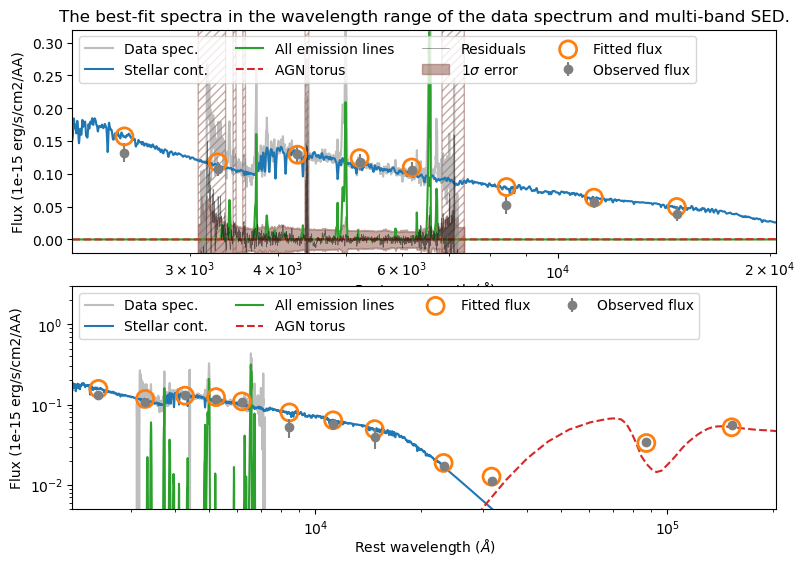

In [101]:
# the following plots show the best-fit model spectra in the full SED range
# the photometric data and the corresponding model fluxes are also shown
tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.08,bottom=0.06,right=0.96,top=0.98,wspace=0,hspace=0.15)

ax2 = plt.subplot(3, 1, 2)
ax2.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', alpha=0.5, label='Data spec.')
ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_ssp_w'], c='C0', label='Stellar cont.')
ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_el_w'], c='C2', label='All emission lines')
ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_torus_w'], '--', c='C3', label='AGN torus')
ax2.plot(FF.spec['wave_w']/tmp_z, FF.spec['fres_w'], c='k', linewidth=.5, alpha=.5, label='Residuals')
ax2.fill_between(FF.spec['wave_w']/tmp_z, -1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 
                 fc='C5', ec='C5', alpha=0.5, label='1$\sigma$ error')
ax2.fill_between(FF.spec['wave_w']/tmp_z, -1*~FF.spec['mask_valid_w'], 1*~FF.spec['mask_valid_w'], 
                 hatch='////', fc='None', ec='C5', alpha=0.5)

ax2.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], FF.phot['ferr_b']+0.1*FF.phot['flux_b'], fmt='o', color='C7', 
             label='Observed flux', zorder=20 )
ax2.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='C1', s=150, linewidth=2, label='Fitted flux', zorder=20 )

ax2.legend(ncol=4, loc=2)
ax2.set_ylim(-0.02,0.32)
ax2.set_xlim(3e3/tmp_z,3e4/tmp_z) 
ax2.set_xscale('log')
ax2.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)
ax2.set_title('The best-fit spectra in the wavelength range of the data spectrum and multi-band SED.')

ax3 = plt.subplot(3, 1, 3)
ax3.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', alpha=0.5, label='Data spec.')
ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_ssp_w'], c='C0', label='Stellar cont.')
ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_el_w'], c='C2', label='All emission lines')
ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_torus_w'], '--', c='C3', label='AGN torus')

ax3.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], 
            FF.phot['ferr_b']+0.1*FF.phot['flux_b'], fmt='o', color='C7', label='Observed flux', zorder=20)
ax3.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='C1', linewidth=2, s=150, label='Fitted flux', zorder=10 )

ax3.legend(ncol=4, loc=2)
ax3.set_ylim(0.005,3)
ax3.set_xlim(3e3/tmp_z,3e5/tmp_z) 
ax3.set_yscale('log'); ax3.set_xscale('log')
ax3.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax3.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

In [121]:
# The best-fit spectra for all mocked input spectra are stored in FF.output_spec_ltw and FF.output_sed_ltw
# FF.output_sed_ltw[i_l, i_t, :] is the best-fit spectra of the (i_t)th model in the (i_l)th mock loop.
print(f'i_t from 0 to {FF.output_sed_ltw.shape[1]-1} represents the model type of'
     +f" {[name[5:-2] for name in [*FF.spec] if name[:4] == 'fmod']}, respectively.")

i_t from 0 to 3 represents the model type of ['ssp', 'el', 'torus', 'tot'], respectively.


Text(0, 0.5, 'Flux (mJy))')

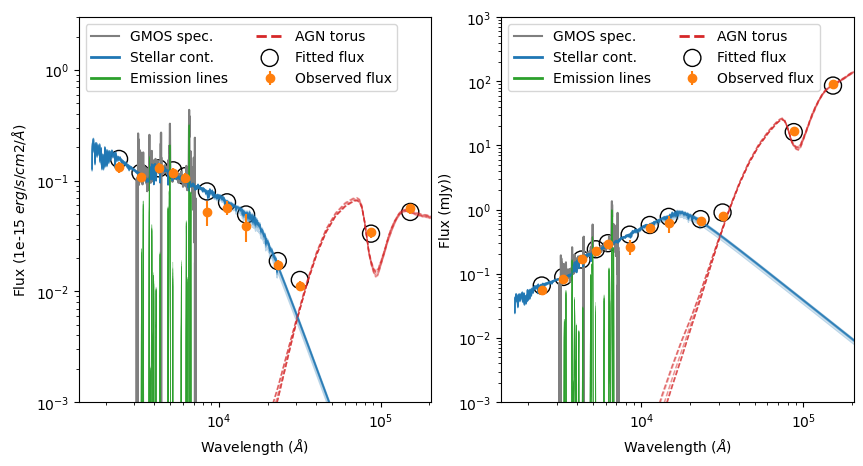

In [113]:
# The following plots show the best-fit spectra for all mocked input spectra
# in flux_lambda (left) and flux_nu (right), respectively. 

tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', label='GMOS spec.')

for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:], '-', c='C0', linewidth=1, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:], '-', c='C2', linewidth=.5, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:], '--', c='C3', linewidth=1, alpha=0.3)
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], FF.phot['ferr_b']+0.1*FF.phot['flux_b'], fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,3); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux ('+str(spec_flux_scale)+' $erg/s/cm2/\AA$)')

ax = plt.subplot(1, 2, 2)
tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.spec['wave_w']) 
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] * tmp_w , c='C7', label='GMOS spec.')

tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.sed['wave_w']) 
for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:] * tmp_w, '-', c='C0', linewidth=1, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:] * tmp_w, '-', c='C2', linewidth=.5, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:] * tmp_w, '--', c='C3', linewidth=1, alpha=0.3)
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

tmp_b = spec_flux_scale * FF.pframe.rFnuFlam_b
plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'] * tmp_b, 
            (FF.phot['ferr_b']+0.1*FF.phot['flux_b']) * tmp_b, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'] * tmp_b, marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,1000); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (mJy))')

# Output best-fit parameters

# Stellar models

In [22]:
# results of stellar components with the main(expertontial)+young(constant) SFH
FF_wSED_biSFH_mock10.output_ssp_to_screen()


Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     0.1342
| Redshift                         =     0.4684 +/- 0.0001
| Velocity dispersion (km/s)       =   348.1712 +/- 13.7576
| Extinction (AV)                  =     1.3057 +/- 0.0457
| log Age_max of CSP (Gyr)         =     0.1877 +/- 0.0403
| log Tau of SFH (Gyr)             =     0.5124 +/- 0.4251
| F5500(rest) (1e-15 erg/s/cm2/AA) =     0.0231 +/- 0.0032
| log L5500(rest) (Lsun/AA)        =     7.3932 +/- 0.0515
| log Mass (all formed) (Msun)     =    10.9363 +/- 0.0982
| log Mass (remainning) (Msun)     =    10.8268 +/- 0.0888
| log M/L5500 (Msun/(Lsun/AA))     =     3.4336 +/- 0.0766
| Lum-weight log Age (Gyr)         =    -0.4712 +/- 0.1517
| Mass-weight log Age (Gyr)        =    -0.1932 +/- 0.1216
| Lum-weight log Metallicity (Z)   =    -1.6990 +/- 0.0000
| Mass-weight log Metallicity (Z)  =    -1.6990 +/- 0.0000

Best-fit stellar properties of the <young> compon

In [48]:
# results are stored in the array FF_wSED_biSFH_mock10.output_ssp_lcp
# output_ssp_lcp[i_l, i_c, i_p] shows the best-fit result of the (i_p)th value of the (i_c)th components in the (i_l)th mocked loop

output_ssp_lcp = copy(FF_wSED_biSFH_mock10.output_ssp_lcp)
output_ssp_vals = copy(FF_wSED_biSFH_mock10.output_ssp_vals)
ssp_val_names = [*output_ssp_vals[[*output_ssp_vals][0]]['mean']]
print(f'Names of the values with i_p from 0 to {len(ssp_val_names)-1} are: {ssp_val_names}')
print()
ssp_mod = FF_wSED_biSFH_mock10.model_dict['ssp']['specmod']
print(f'Values with i_p from {len(ssp_val_names)} to {output_ssp_lcp.shape[2]} are the intrinsic flux of CSP with each metallicity, '
     +f'at rest {ssp_mod.w_norm}AA, in unit of {FF_wSED_biSFH_mock10.spec_flux_scale} erg/s/cm2/AA.')

Names of the values with i_p from 0 to 15 are: ['chi_sq', 'ssp_voff', 'ssp_fwhm', 'ssp_AV', 'logcsp_age', 'logsfh_tau', 'redshift', 'flux_wavenorm', 'loglum_wavenorm', 'logmass_formed', 'logmass_remaining', 'logmtol', 'logage_lw', 'logage_mw', 'logmet_lw', 'logmet_mw']

Values with i_p from 16 to 20 are the intrinsic flux of CSP with each metallicity, at rest 5500AA, in unit of 1e-15 erg/s/cm2/AA.


In [53]:
# example
i_p = np.where(np.array(ssp_val_names) == 'redshift')[0][0]
i_c = 0 # i.e., from the first stellar component
print('Best-fit redshift from stellar continuum:', FF_wSED_biSFH_mock10.output_ssp_lcp[:,i_c,i_p].mean(), 
      '+-', FF_wSED_biSFH_mock10.output_ssp_lcp[:,i_c,i_p].std())

Best-fit redshift from stellar continuum: 0.4683584888673376 +- 8.584939349119953e-05


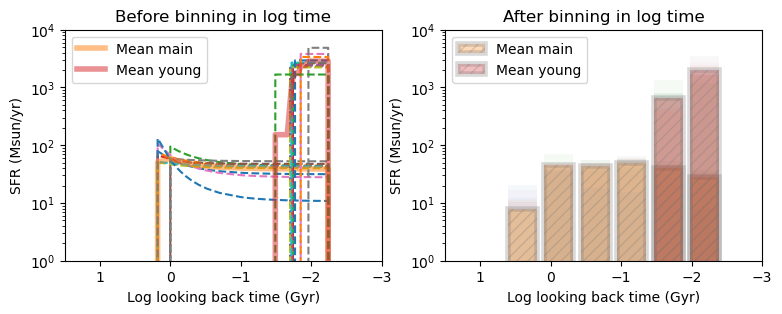

In [18]:
# the reconctructed SFH before and after a binning in log time
FF_wSED_biSFH_mock10.reconstruct_sfh(num_bins=10)
# num_bins in the number of bins in the entire age range of popstar library
# the dashed (left) curves and light color bars (right) are results in each mocked loop
# the solid (left) and dark color bars (right) are averaged results

In [31]:
# in order to obtain the values of SFH:
SFH_lcza, age_a = FF_wSED_biSFH_mock10.reconstruct_sfh(return_sfh=True, plot=False) # before binning
SFH_lczb, age_b = FF_wSED_biSFH_mock10.reconstruct_sfh(return_sfh=True, plot=False, num_bins=10) # after binning
# format SFH_lcza[i_l, i_c, i_z, :] shows the SFH with the (i_z)th metallicity of the (i_c)th components in the (i_l)th mocked loop
# _a and _b represents the original ages and the binned ages, in log Gyr
# popstar has four metallicities 
print('Available metallicities (Z):', np.unique(FF_wSED_biSFH_mock10.model_dict['ssp']['specmod'].met_m))
# in above fitting, only solar metallicity is enabled ('met_sel' in the input ssp_config)

Available metallicities: [0.004 0.008 0.02  0.05 ]


In [55]:
# results of stellar components with the nonparametric SFH
FF_wSED_npSFH_mock10.output_ssp_to_screen()


Best-fit single stellar populations of nonparametric SFH
-----------------------------------------------------------------------
|  ID  | Age (Gyr)  | Metallicity | Coeff.mean | Coeff.rms | log(M/L) |
-----------------------------------------------------------------------
| 0236 |   0.0060   |    0.0200   |   0.1467   |   0.0638  |  2.3737  |
| 0237 |   0.0065   |    0.0200   |   0.2591   |   0.0645  |  2.3576  |
| 0238 |   0.0071   |    0.0200   |   0.0369   |   0.0937  |  2.3097  |
| 0239 |   0.0072   |    0.0200   |   0.1000   |   0.0954  |  2.3122  |
| 0245 |   0.0087   |    0.0200   |   0.1561   |   0.0618  |  2.4812  |
| 0246 |   0.0089   |    0.0200   |   0.1066   |   0.0659  |  2.5491  |
| 0275 |   0.0501   |    0.0200   |   0.0499   |   0.0944  |  2.9844  |
| 0276 |   0.0550   |    0.0200   |   0.0954   |   0.0967  |  3.0155  |
-----------------------------------------------------------------------
Coeff is the intrinsic flux at rest 5500AA in unit of 1e-15 erg/s/cm2/AA.

Bes

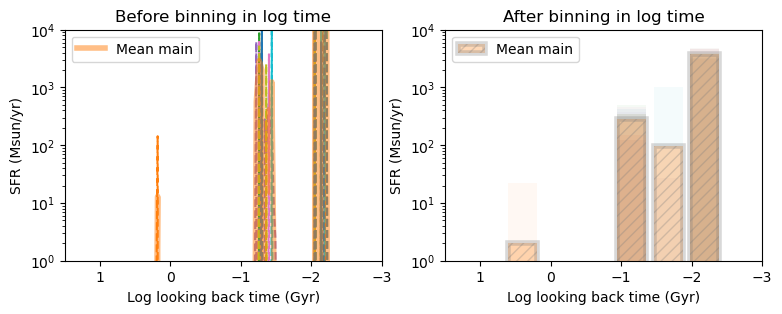

In [56]:
# the reconctructed SFH before and after a binning in log time
FF_wSED_npSFH_mock10.reconstruct_sfh(num_bins=10)
# num_bins in the number of bins in the entire age range of popstar library
# the dashed (left) curves and light color bars (right) are results in each mocked loop
# the solid (left) and dark color bars (right) are averaged results

In [ ]:
# please follow the first case (i.e., FF_wSED_biSFH_mock10) to obtain the output values of parameters and SFH for FF_wSED_npSFH_mock10.

# Emission lines

In [135]:
# results of emission lines
FF_wSED_biSFH_mock10.output_el_to_screen()
# In the table, the three columns represents the three emission line components, which are set in the input el_config.
# the 1st row is the chi-square 
# the 2-5th rows are best-fit values, i.e., velocity shift, width, AV (from Balmer decrement), and [SII]6716/6731 ratio
# the following rows are the observed (extinct) fluxes in 1e15 erg/s/cm2


Best-fit emission line components
-------------------------------------------------------------------------------------
|   Par/Line Name    |        NLR         |     outflow_1      |     outflow_2      |
-------------------------------------------------------------------------------------
|       Chi^2        |     0.19 +-   0.02 |     0.19 +-   0.02 |     0.19 +-   0.02 |
|    Voff (km/s)     | -  22.82 +-   2.69 | -1032.52 +-  21.54 | -2350.39 +- 123.20 |
|    FWHM (km/s)     |   568.34 +-  11.49 |  1498.53 +-  37.09 |  2206.15 +- 241.40 |
| AV (Balmer decre.) |     2.79 +-   0.14 |     1.09 +-   0.31 |     1.45 +-   1.15 |
|   [SII]6716/6731   |     1.04 +-   0.05 |     1.45 +-   0.00 |     1.04 +-   0.31 |
|     Ha 6564.63     |     5.24 +-   0.17 |     2.96 +-   0.21 |     0.07 +-   0.25 |
|     Hb 4862.69     |     0.82 +-   0.03 |     0.75 +-   0.03 |     0.00 +-   0.00 |
|     Hg 4341.69     |     0.27 +-   0.01 |     0.31 +-   0.02 |     0.00 +-   0.00 |
|     Hd 4102.90   

In [137]:
# Results are stored in FF_wSED_biSFH_mock10.output_el_lcp
# output_el_lcp[i_l, i_c, i_p] shows the best-fit result of the (i_p)th parameter of the (i_c)th components in the (i_l)th mocked loop
# Components: NLR, outflow_1, outflow_2 (in this test case)
# Parameters: (0) chi_sq (1) voff (km/s) (2) fwhm (km/s) (3) AV (from Balmer decrement) (4) [SII]6716/6731 ratio
# (5--) observed flux (spec_flux_scale * erg/s/cm2) of each line

# for example
print('Best-fit narrow line velocity FWHM:', FF_wSED_biSFH_mock10.output_el_lcp[:,0,2].mean(), '+-', 
      FF_wSED_biSFH_mock10.output_el_lcp[:,0,2].std())

line_name = '[OIII]b'
i_line = np.where(FF_wSED_biSFH_mock10.model_dict['el']['specmod'].line_name_n == line_name)[0][0]+5
print('Best-fit [OIII]5007 outflow_1 flux:', FF_wSED_biSFH_mock10.output_el_lcp[:,1,i_line].mean(), '+-', 
      FF_wSED_biSFH_mock10.output_el_lcp[:,1,i_line].std())

Best-fit narrow line velocity FWHM: 567.8646804089296 +- 10.954195597699611
Best-fit [OIII]5007 outflow_1 flux: 7.80911762943885 +- 0.30629617388268093


# AGN torus 

In [155]:
FF_wSED_biSFH_mock10.output_torus_to_screen()


Best-fit torus components
| Opacity               = 10.9919 +/- 0.0118
| Out/in radii ratio    = 25.7584 +/- 0.6158
| Half OpenAng (degree) = 75.6769 +/- 4.6614
| Inclination (degree)  = 89.8340 +/- 0.2049
| Torus Lum (1e12 Lsun) = 5.7282 +/- 0.2895


In [156]:
# Results are stored in FF_wSED_biSFH_mock10.output_torus_lcp
# output_el_lcp[i_l, i_c, i_p] shows the best-fit result of the (i_p)th parameter of the (i_c)th components in the (i_l)th mocked loop
# Since only one component is used in the case, i_c = 0.
# Parameters: (0) chi_sq (1) voff (km/s) (2) opacity (tau) (3) half opening angel (degree) 
# (4) ratio of radius_out to radius_in (5) inclination angle (degree)
# (6) the total torus luminosity, in unit of 1e12 Lsun.